In [24]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "../../Plant_Images (copy)"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("Plant_Images",
shuffle=True,batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 2152 files belonging to 3 classes.


In [10]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset.class_names)

3

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [13]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

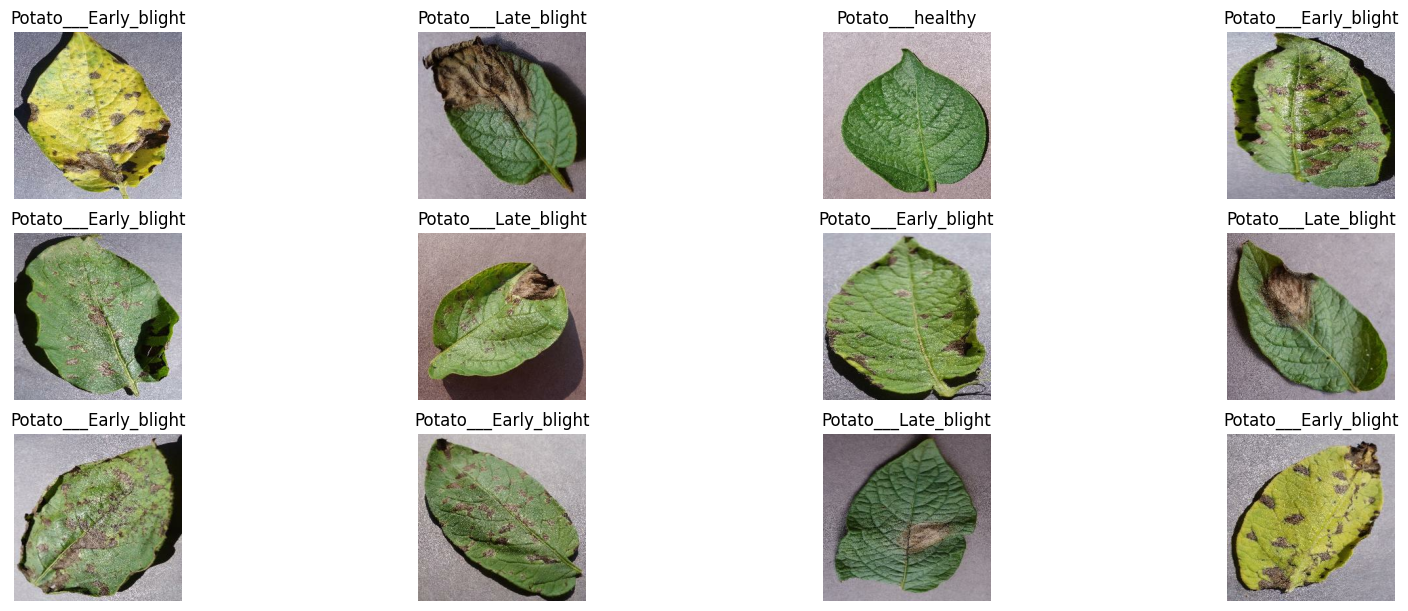

In [15]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(5):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [54]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50
54/54 [==============================] - 34s 635ms/step - loss: 0.0278 - accuracy: 0.9906 - val_loss: 0.0261 - val_accuracy: 0.9896
Epoch 2/50
54/54 [==============================] - 36s 672ms/step - loss: 0.0356 - accuracy: 0.9894 - val_loss: 0.0505 - val_accuracy: 0.9844
Epoch 3/50
54/54 [==============================] - 37s 678ms/step - loss: 0.0316 - accuracy: 0.9847 - val_loss: 0.1374 - val_accuracy: 0.9531
Epoch 4/50
54/54 [==============================] - 35s 656ms/step - loss: 0.0530 - accuracy: 0.9795 - val_loss: 0.0435 - val_accuracy: 0.9844
Epoch 5/50
54/54 [==============================] - 37s 682ms/step - loss: 0.0201 - accuracy: 0.9947 - val_loss: 0.0494 - val_accuracy: 0.9792
Epoch 6/50
54/54 [==============================] - 37s 693ms/step - loss: 0.0383 - accuracy: 0.9847 - val_loss: 0.0372 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 36s 663ms/step - loss: 0.0380 - accuracy: 0.9818 - val_loss: 0.0070 - val_accuracy: 1.0000

In [58]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 152ms/step - loss: 0.1124 - accuracy: 0.9570


In [59]:
scores

[0.11243795603513718, 0.95703125]

In [22]:
import os
model_version = max([int(i) for i in (os.listdir("../Models")+[0])]) + 1
model.save(f"../Models/{model_version}")

INFO:tensorflow:Assets written to: ../Models/3\assets


INFO:tensorflow:Assets written to: ../Models/3\assets
